In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models
from torchmetrics.functional import f1_score, precision
from torchmetrics import ConfusionMatrix
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
labels = ["apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare", "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito", "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake", "ceviche", "cheese_plate", "cheesecake", "chicken_curry", "chicken_quesadilla", "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder", "club_sandwich", "crab_cakes", "creme_brulee", "croque_madame", "cup_cakes", "deviled_eggs", "donuts", "dumplings", "edamame", "eggs_benedict", "escargots", "falafel", "filet_mignon", "fish_and_chips", "foie_gras", "french_fries", "french_onion_soup", "french_toast", "fried_calamari", "fried_rice", "frozen_yogurt", "garlic_bread", "gnocchi", "greek_salad", "grilled_cheese_sandwich", "grilled_salmon", "guacamole", "gyoza", "hamburger", "hot_and_sour_soup", "hot_dog", "huevos_rancheros", "hummus", "ice_cream", "lasagna", "lobster_bisque", "lobster_roll_sandwich", "macaroni_and_cheese", "macarons", "miso_soup", "mussels", "nachos", "omelette", "onion_rings", "oysters", "pad_thai", "paella", "pancakes", "panna_cotta", "peking_duck", "pho", "pizza", "pork_chop", "poutine", "prime_rib", "pulled_pork_sandwich", "ramen", "ravioli", "red_velvet_cake", "risotto", "samosa", "sashimi", "scallops", "seaweed_salad", "shrimp_and_grits", "spaghetti_bolognese", "spaghetti_carbonara", "spring_rolls", "steak", "strawberry_shortcake", "sushi", "tacos", "takoyaki", "tiramisu", "tuna_tartare", "waffles"]

In [3]:
test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder("../data/food-101/test", transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
test_data_size = len(test_data)

In [4]:
model_name = "unfreeze_{}.pth".format(56)
checkpoint = torch.load("../models/{}".format(model_name), map_location="cpu")

model = models.resnet34(pretrained=False)

model.fc = nn.Linear(in_features=512, out_features=101, bias=True)
model.load_state_dict(checkpoint["model_state"], strict=False)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
loss = 0.0
top1_accuracy = 0.0
top3_accuracy = 0.0
top5_accuracy = 0.0
predicts = torch.tensor([]).to(device)
targets = torch.tensor([]).to(device)

with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to(device), target.to(device)
        outputs = model(input)
        loss += loss_fn(outputs, target)
        target = target.view(-1, 1)
        _, top1_output = torch.topk(outputs, 1, dim=-1)
        _, top3_output = torch.topk(outputs, 3, dim=-1)
        _, top5_output = torch.topk(outputs, 5, dim=-1)
        top1_accuracy += (top1_output == target).sum()
        top3_accuracy += (top3_output == target).sum()
        top5_accuracy += (top5_output == target).sum()
        predicts = torch.cat((predicts, top1_output.view(-1)), dim=0)
        targets = torch.cat((targets, target.view(-1)), dim=0)

In [6]:
avg_top1_accuracy = top1_accuracy / test_data_size
avg_top3_accuracy = top3_accuracy / test_data_size
avg_top5_accuracy = top5_accuracy / test_data_size
avg_loss = loss / test_data_size
print("top1 accuracy {:.4f}\t top3 accuracy {:.4f}\t top5 accuracy {:.4f}".format(avg_top1_accuracy, avg_top3_accuracy, avg_top5_accuracy))

top1 accuracy 0.8193	 top3 accuracy 0.9282	 top5 accuracy 0.9557


In [7]:
f1 = f1_score(predicts.int(), targets.int(), average="macro", num_classes=101)
prec = precision(predicts.int(), targets.int(), average="macro", num_classes=101)
print("f1 score {:.4f}\t precision {:.4f}".format(f1, prec))

f1 score 0.8190	 precision 0.8209


In [30]:
f = open('confusion_matrix.txt', 'w')
confmat = ConfusionMatrix(num_classes=101).to(device)
torch.set_printoptions(profile="full")
print(confmat(predicts.int(), targets.int()), file=f)
torch.set_printoptions(profile="default")
f.close()

In [18]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
cf_matrix = confusion_matrix(targets.int().cpu(), predicts.int().cpu())
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in labels], columns = [i for i in labels])

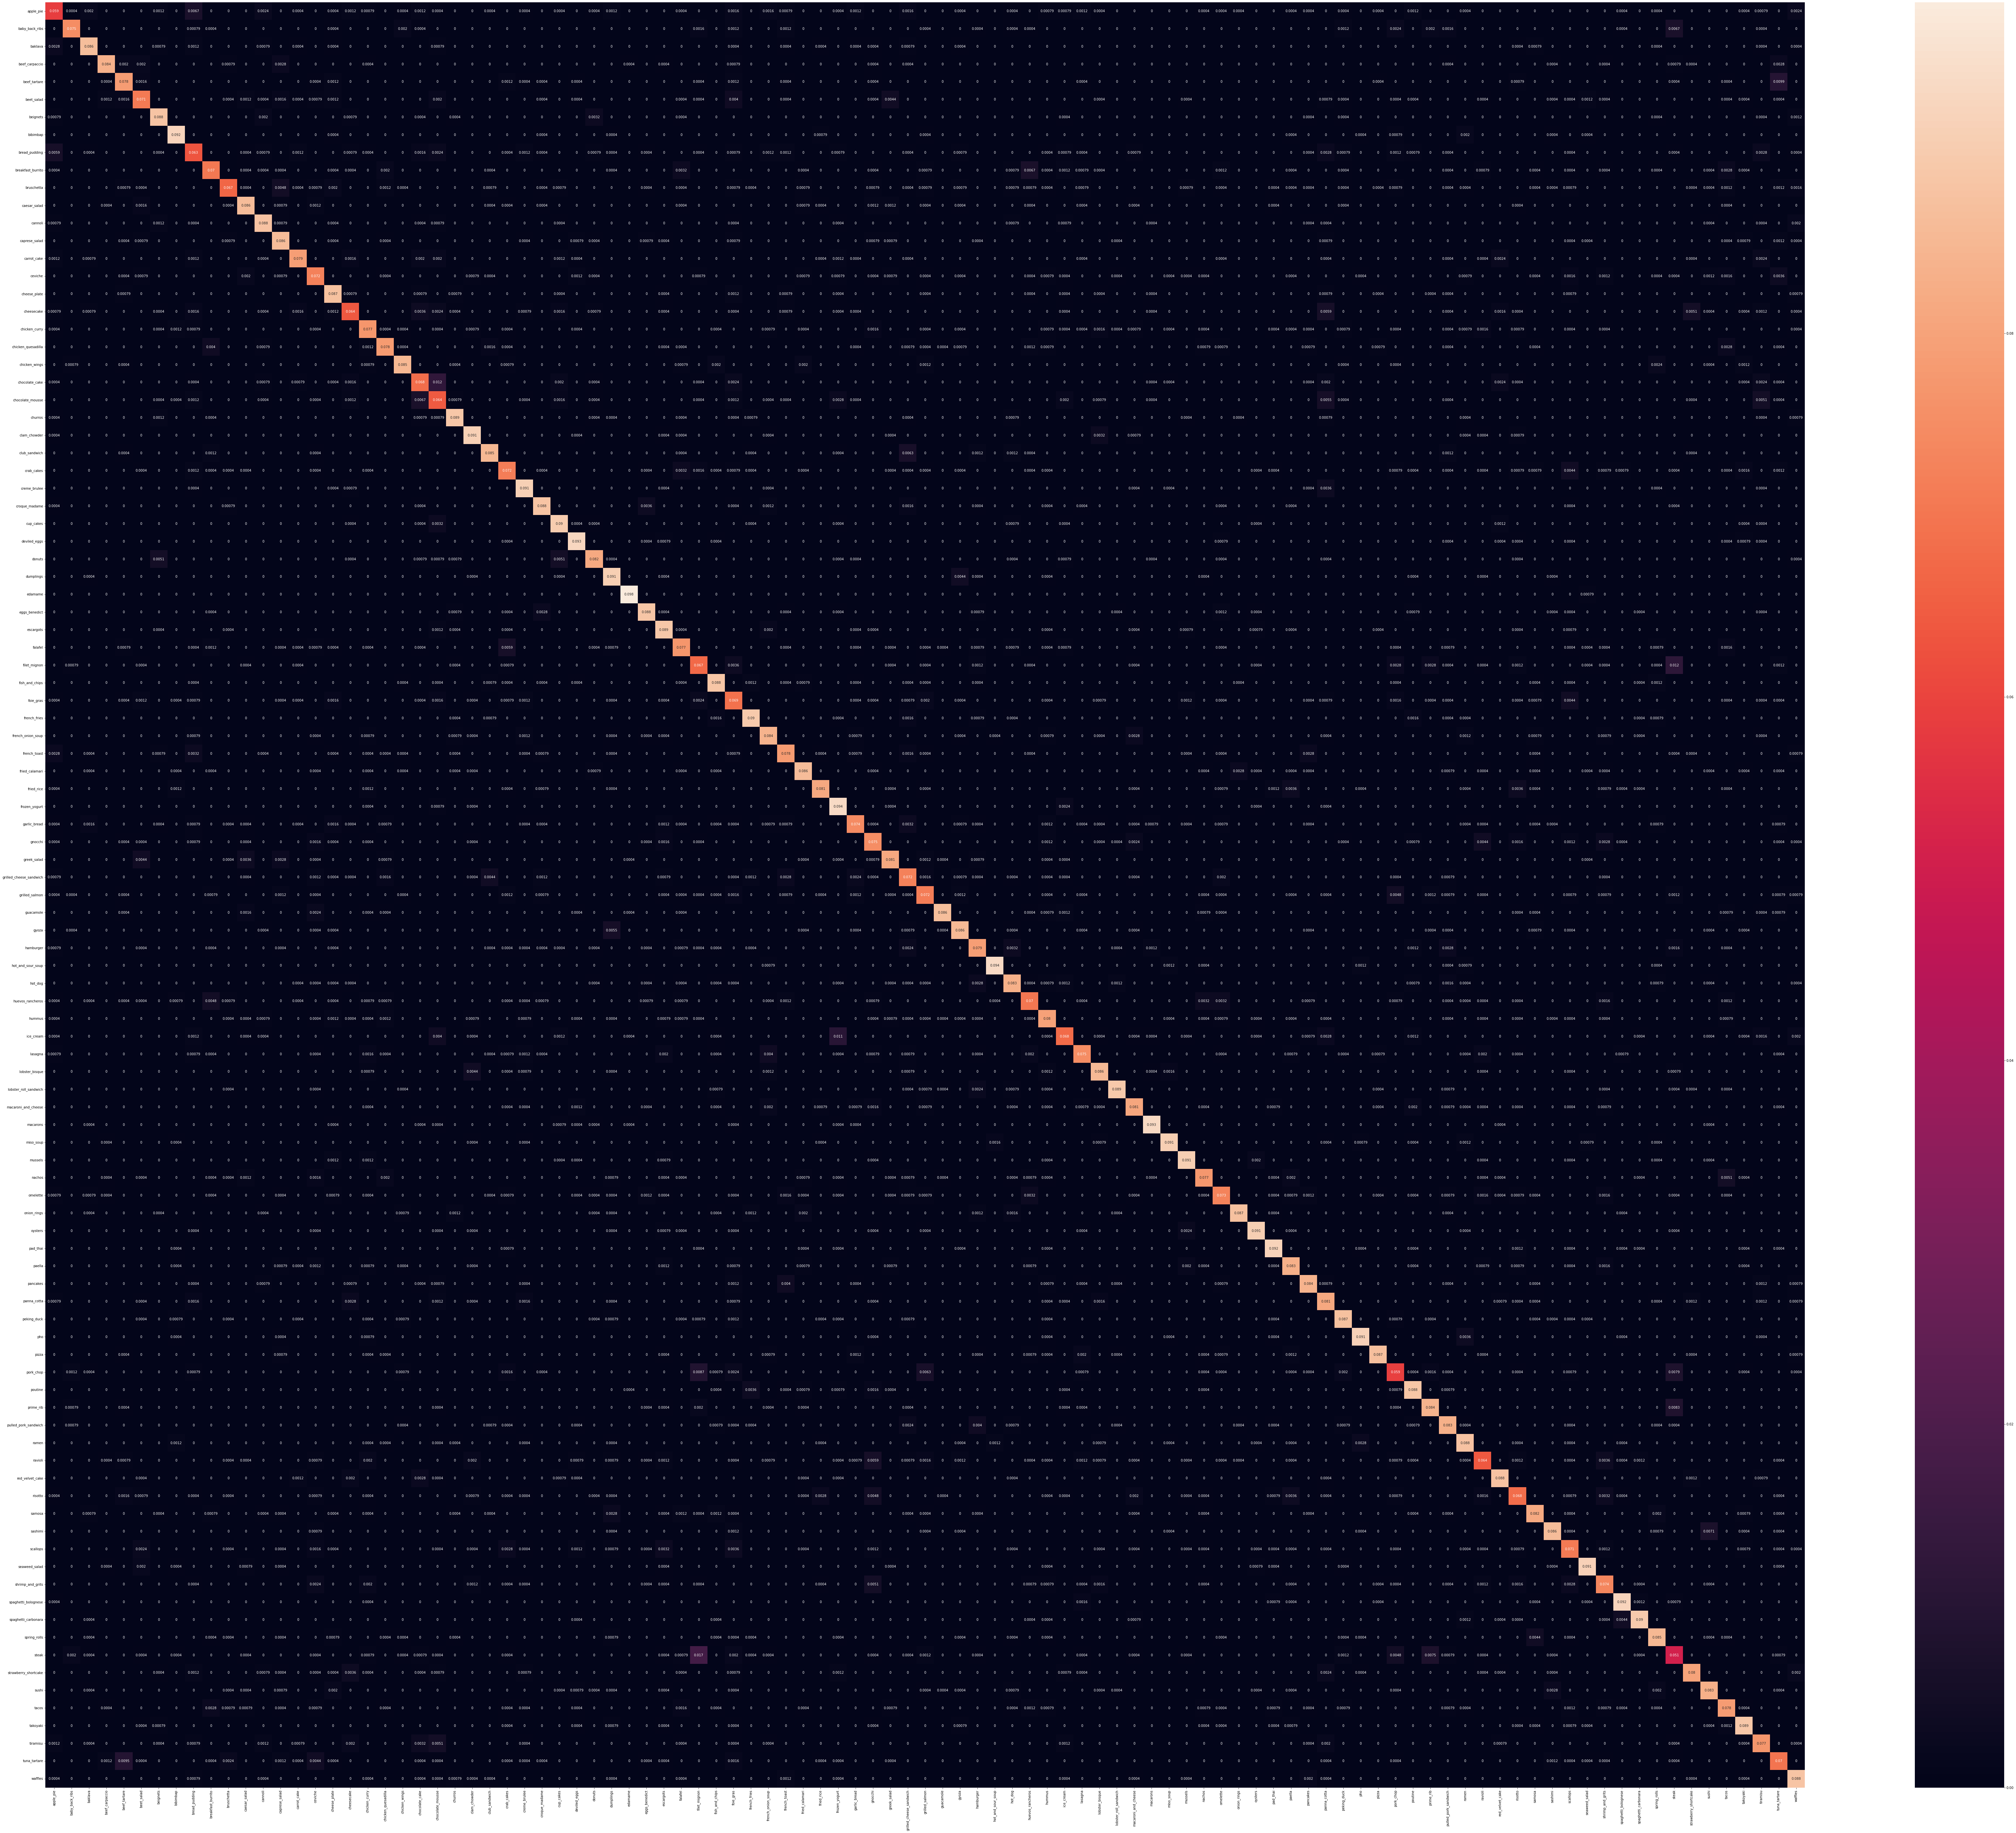

In [22]:
plt.figure(figsize = (120,100))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')